Build a model to predict "mean_temp" with a RMSE of 3 or less.
Use MLflow to log any models you train, their hyperparameters, and respective RMSE scores (ensuring you include "rmse" as part of the metric name).
Create a variable called experiment_results equal to a search of all MLflow runs completed.

![tower_bridge](tower_bridge.jpg)

As the climate changes, predicting the weather becomes ever more important for businesses. You have been asked to support on a machine learning project with the aim of building a pipeline to predict the climate in London, England. Specifically, the model should predict mean temperature in degrees Celsius (°C).

Since the weather depends on a lot of different factors, you will want to run a lot of experiments to determine what the best approach is to predict the weather. In this project, you will run experiments for different regression models predicting the mean temperature, using a combination of `sklearn` and `mlflow`.

You will be working with data stored in `london_weather.csv`, which contains the following columns:
- **date** - recorded date of measurement - (**int**)
- **cloud_cover** - cloud cover measurement in oktas - (**float**)
- **sunshine** - sunshine measurement in hours (hrs) - (**float**)
- **global_radiation** - irradiance measurement in Watt per square meter (W/m2) - (**float**)
- **max_temp** - maximum temperature recorded in degrees Celsius (°C) - (**float**)
- **mean_temp** - **target** mean temperature in degrees Celsius (°C) - (**float**)
- **min_temp** - minimum temperature recorded in degrees Celsius (°C) - (**float**)
- **precipitation** - precipitation measurement in millimeters (mm) - (**float**)
- **pressure** - pressure measurement in Pascals (Pa) - (**float**)
- **snow_depth** - snow depth measurement in centimeters (cm) - (**float**)

In [4]:
# Run this cell to install mlflow
!pip install mlflow

Defaulting to user installation because normal site-packages is not writeable


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
 9   snow_depth        13900 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB


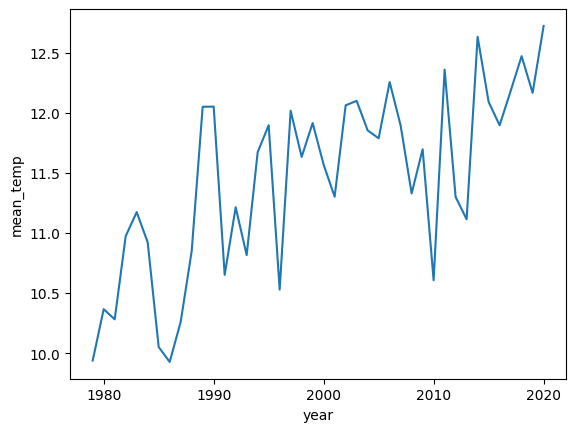

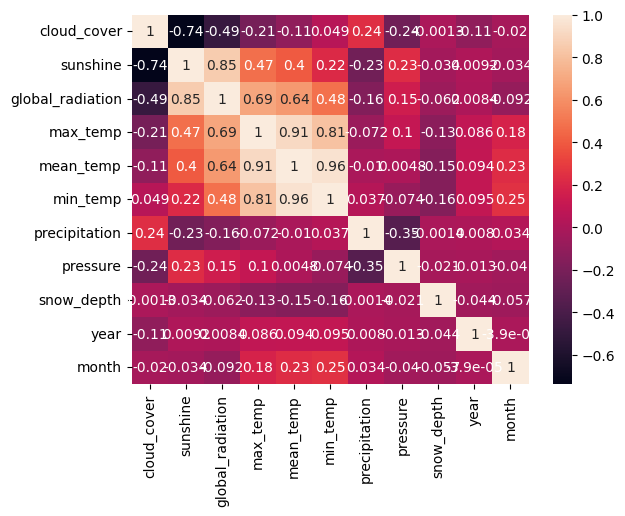

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.rmse_lr,metrics.rmse_tr,metrics.rmse_fr,params.max_depth,tags.mlflow.log-model.history,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.runName,tags.mlflow.source.type
0,98a94400757b4052831ff8991750a8b1,0,FINISHED,file:///work/files/workspace/mlruns/0/98a94400...,2023-11-22 20:52:04.607000+00:00,2023-11-22 20:52:13.917000+00:00,3.866773,3.807963,2.893355,20,"[{""run_id"": ""98a94400757b4052831ff8991750a8b1""...",repl,/usr/lib/python3/dist-packages/python_kernel/k...,run_4,LOCAL
1,7226bb48da9f41d5b5ba85e3d9d9903b,0,FINISHED,file:///work/files/workspace/mlruns/0/7226bb48...,2023-11-22 20:51:56.555000+00:00,2023-11-22 20:52:04.585000+00:00,3.866773,3.068346,2.814782,10,"[{""run_id"": ""7226bb48da9f41d5b5ba85e3d9d9903b""...",repl,/usr/lib/python3/dist-packages/python_kernel/k...,run_3,LOCAL
2,f010b9972d56442c8cf116b4e7dd9885,0,FINISHED,file:///work/files/workspace/mlruns/0/f010b997...,2023-11-22 20:51:49.366000+00:00,2023-11-22 20:51:56.535000+00:00,3.866773,3.027733,2.967462,5,"[{""run_id"": ""f010b9972d56442c8cf116b4e7dd9885""...",repl,/usr/lib/python3/dist-packages/python_kernel/k...,run_2,LOCAL
3,8f226b5197084d0587262ca4ec004ff9,0,FINISHED,file:///work/files/workspace/mlruns/0/8f226b51...,2023-11-22 20:51:42.536000+00:00,2023-11-22 20:51:49.345000+00:00,3.866773,3.917318,3.832143,2,"[{""run_id"": ""8f226b5197084d0587262ca4ec004ff9""...",repl,/usr/lib/python3/dist-packages/python_kernel/k...,run_1,LOCAL
4,341129bc38014ef899babc74ff1ddbe9,0,FINISHED,file:///work/files/workspace/mlruns/0/341129bc...,2023-11-22 20:51:35.585000+00:00,2023-11-22 20:51:42.515000+00:00,3.866773,4.752035,4.694655,1,"[{""run_id"": ""341129bc38014ef899babc74ff1ddbe9""...",repl,/usr/lib/python3/dist-packages/python_kernel/k...,run_0,LOCAL
5,2a3acb8f9ef94561b2ba159211836449,0,FINISHED,file:///work/files/workspace/mlruns/0/2a3acb8f...,2023-11-22 20:51:20.396000+00:00,2023-11-22 20:51:29.624000+00:00,3.866773,3.807963,2.893355,20,"[{""run_id"": ""2a3acb8f9ef94561b2ba159211836449""...",repl,/usr/lib/python3/dist-packages/python_kernel/k...,run_4,LOCAL
6,a1626c8da8f741d295000ff391139c4b,0,FINISHED,file:///work/files/workspace/mlruns/0/a1626c8d...,2023-11-22 20:51:12.352000+00:00,2023-11-22 20:51:20.374000+00:00,3.866773,3.068346,2.814782,10,"[{""run_id"": ""a1626c8da8f741d295000ff391139c4b""...",repl,/usr/lib/python3/dist-packages/python_kernel/k...,run_3,LOCAL
7,b7a879b6f1a14efb948476ee8cd0811e,0,FINISHED,file:///work/files/workspace/mlruns/0/b7a879b6...,2023-11-22 20:51:05.068000+00:00,2023-11-22 20:51:12.331000+00:00,3.866773,3.027733,2.967462,5,"[{""run_id"": ""b7a879b6f1a14efb948476ee8cd0811e""...",repl,/usr/lib/python3/dist-packages/python_kernel/k...,run_2,LOCAL
8,59b131ac1524487c8e5049ed531e1c7e,0,FINISHED,file:///work/files/workspace/mlruns/0/59b131ac...,2023-11-22 20:50:58.351000+00:00,2023-11-22 20:51:05.046000+00:00,3.866773,3.917318,3.832143,2,"[{""run_id"": ""59b131ac1524487c8e5049ed531e1c7e""...",repl,/usr/lib/python3/dist-packages/python_kernel/k...,run_1,LOCAL
9,4374f6c040284f5381abcad327b1133d,0,FINISHED,file:///work/files/workspace/mlruns/0/4374f6c0...,2023-11-22 20:50:51.284000+00:00,2023-11-22 20:50:58.329000+00:00,3.866773,4.752035,4.694655,1,"[{""run_id"": ""4374f6c040284f5381abcad327b1133d""...",repl,/usr/lib/python3/dist-packages/python_kernel/k...,run_0,LOCAL


In [5]:
# Run this cell to import the modules you require
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Import the data and perform exploratory data analysis
weather = pd.read_csv("london_weather.csv")
weather.info()

weather["date"] = pd.to_datetime(weather["date"], format="%Y%m%d")
weather["year"] = weather["date"].dt.year
weather['month'] = weather['date'].dt.month
weather_metrics = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'mean_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth']
weather_per_month = weather.groupby(['year', 'month'], as_index = False)[weather_metrics].mean()

sns.lineplot(x="year", y="mean_temp", data=weather_per_month, ci=None)
plt.show()
sns.heatmap(weather.corr(), annot=True)
plt.show()

# Choose features, define the target, and drop null values
feature_selection = ['month', 'cloud_cover', 'sunshine', 'precipitation', 'pressure', 'global_radiation']
target_var = 'mean_temp'
weather = weather.dropna(subset=['mean_temp'])

# Subset feature and target sets
X = weather[feature_selection]    
y = weather[target_var]
    
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
    
# Impute missing values
imputer = SimpleImputer(strategy="mean")
# Fit on the training data
X_train = imputer.fit_transform(X_train)
# Transform on the test data
X_test  = imputer.transform(X_test)
    
# Scale the data
scaler = StandardScaler()
# Fit on the training data
X_train = scaler.fit_transform(X_train)
# Transform on the test data
X_test = scaler.transform(X_test)  

# Predict, evaluate, and log the parameters and metrics of your models
for idx, depth in enumerate([1, 2, 5, 10, 20]): 
    run_name = f"run_{idx}"
    with mlflow.start_run(run_name=run_name):
        # Create models
        lin_reg = LinearRegression().fit(X_train, y_train)
        tree_reg = DecisionTreeRegressor(random_state=42, max_depth=depth).fit(X_train, y_train)
        forest_reg = RandomForestRegressor(random_state=42, max_depth=depth).fit(X_train, y_train)
        # Log models
        mlflow.sklearn.log_model(lin_reg, "lin_reg")
        mlflow.sklearn.log_model(tree_reg, "tree_reg")
        mlflow.sklearn.log_model(forest_reg, "forest_reg")
        # Evaluate performance
        y_pred_lin_reg = lin_reg.predict(X_test)
        lin_reg_rmse = mean_squared_error(y_test, y_pred_lin_reg, squared=False)
        y_pred_tree_reg = tree_reg.predict(X_test)
        tree_reg_rmse = mean_squared_error(y_test, y_pred_tree_reg, squared=False)
        y_pred_forest_reg = forest_reg.predict(X_test)
        forest_reg_rmse = mean_squared_error(y_test, y_pred_forest_reg, squared=False)
        # Log performance
        mlflow.log_param("max_depth", depth)
        mlflow.log_metric("rmse_lr", lin_reg_rmse)
        mlflow.log_metric("rmse_tr", tree_reg_rmse)
        mlflow.log_metric("rmse_fr", forest_reg_rmse)
        
# Search the runs for the experiment's results
experiment_results = mlflow.search_runs()
experiment_results